In [1]:
!pip install torch opencv-python pandas
!pip install kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [2]:
!kaggle datasets download -d ayushspai/sportsmot -q
!unzip -q sportsmot.zip -d SportsMOT
!rm sportsmot.zip
!cp -r /content/SportsMOT/sportsmot_publish/dataset/val/* /content/SportsMOT/sportsmot_publish/dataset/train > /dev/null 2>&1

Streaming output truncated to the last 5000 lines.
  inflating: SportsMOT/sportsmot_publish/dataset/val/v_ITo3sCnpw_k_c012/img1/000828.jpg  
  inflating: SportsMOT/sportsmot_publish/dataset/val/v_ITo3sCnpw_k_c012/img1/000829.jpg  
  inflating: SportsMOT/sportsmot_publish/dataset/val/v_ITo3sCnpw_k_c012/img1/000830.jpg  
  inflating: SportsMOT/sportsmot_publish/dataset/val/v_ITo3sCnpw_k_c012/img1/000831.jpg  
  inflating: SportsMOT/sportsmot_publish/dataset/val/v_ITo3sCnpw_k_c012/img1/000832.jpg  
  inflating: SportsMOT/sportsmot_publish/dataset/val/v_ITo3sCnpw_k_c012/img1/000833.jpg  
  inflating: SportsMOT/sportsmot_publish/dataset/val/v_ITo3sCnpw_k_c012/img1/000834.jpg  
  inflating: SportsMOT/sportsmot_publish/dataset/val/v_ITo3sCnpw_k_c012/img1/000835.jpg  
  inflating: SportsMOT/sportsmot_publish/dataset/val/v_ITo3sCnpw_k_c012/img1/000836.jpg  
  inflating: SportsMOT/sportsmot_publish/dataset/val/v_ITo3sCnpw_k_c012/img1/000837.jpg  
  inflating: SportsMOT/sportsmot_publish/dataset/

In [3]:
import os
import cv2
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, ColorJitter

import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Dataset

In [22]:
import os

def load_football_sequences(splits_dir):
    """
    Load football sequences for a specific split (train, test, valid).

    Args:
        splits_dir (str): Path to the splits_txt folder
        split_name (str): Name of the split (train, test, valid)

    Returns:
        list: List of sequence names for football in the specified split
    """
    football_file = os.path.join(splits_dir, "football.txt")
    with open(football_file, "r") as f:
        all_sequences = f.read().splitlines()

    return all_sequences

In [23]:
class FootballDataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        splits_dir = os.path.join(root_dir, "splits_txt")
        self.football_sequences = load_football_sequences(splits_dir)

        self.sequences = []
        for seq in self.football_sequences:
            seq_path = os.path.join(root_dir, "dataset", split, seq)
            if os.path.exists(seq_path):
                self.sequences.append(seq)

        self.annotations = {}
        for seq in self.sequences:
            gt_file = os.path.join(root_dir, "dataset", split, seq, "gt", "gt.txt")
            if os.path.exists(gt_file):
                self.annotations[seq] = self._load_annotations(gt_file)

        self.default_transform = Compose([
            ToTensor(),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def _load_annotations(self, gt_file):
        """Load annotations into {frame_id: list(annotations)} format"""
        df = pd.read_csv(gt_file, header=None)
        df.columns = [
            "frame_id", "object_id", "x", "y", "w", "h",
            "conf", "class_id", "visibility"
        ]

        annotations = {}
        for frame_id, group in df.groupby("frame_id"):
            annotations[frame_id] = {
                "boxes": group[["x", "y", "w", "h"]].values.astype("float32"),
                "object_ids": group["object_id"].values.astype("int32"),
                "classes": group["class_id"].values.astype("int32")
            }
        return annotations

    def __len__(self):
        return sum(len(ann) for ann in self.annotations.values())

    def __getitem__(self, idx):
        for seq in self.sequences:
            seq_ann = self.annotations[seq]
            if idx < len(seq_ann):
                frame_id = list(seq_ann.keys())[idx]
                break
            idx -= len(seq_ann)
        else:
            raise IndexError("Index out of range")

        img_path = os.path.join(self.root_dir, "dataset", self.split, seq, "img1", f"{frame_id:06d}.jpg")
        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        ann = self.annotations[seq][frame_id]

        if self.transform:
            image = self.transform(image)
        else:
            image = self.default_transform(image)

        return image, {
            "boxes": torch.tensor(ann["boxes"]),
            "object_ids": torch.tensor(ann["object_ids"]),
            "classes": torch.tensor(ann["classes"]),
            "frame_id": frame_id,
            "sequence": seq
        }

## Data Loader

In [24]:
def custom_collate(batch):
    images = torch.stack([item[0] for item in batch])
    targets = [item[1] for item in batch]
    return images, targets

In [47]:
dataset_dir = "/content/SportsMOT/sportsmot_publish"

transform = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = FootballDataset(root_dir=dataset_dir, split="train", transform=transform)

train_size = int(0.8 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(
    dataset, [train_size, valid_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=custom_collate, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=custom_collate, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=custom_collate, num_workers=2)

In [48]:
len(train_loader), len(test_loader), len(valid_loader)

(4034, 505, 505)

## Visualization

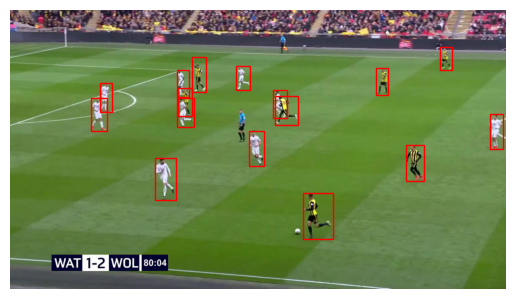

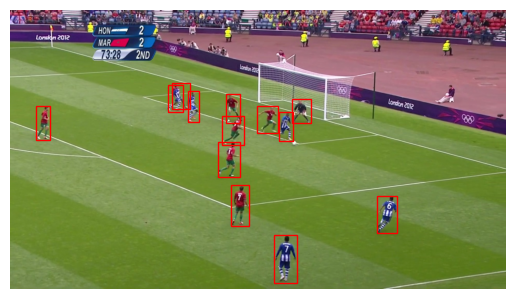

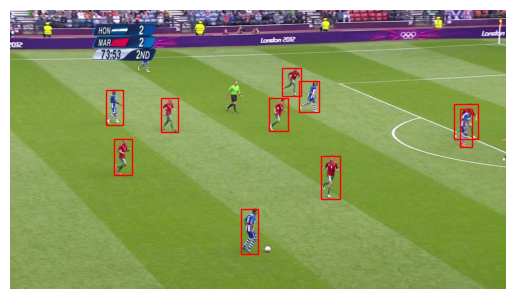

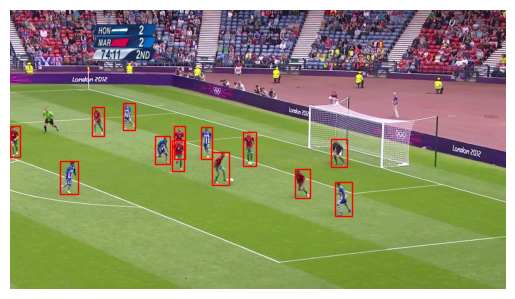

In [50]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def visualize_sample(image, boxes, object_ids, classes):
    image = image.permute(1, 2, 0).numpy()
    image = (image * std) + mean
    image = (image * 255).astype("uint8")
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for box, obj_id, cls_id in zip(boxes, object_ids, classes):
        x, y, w, h = box
        color = 'r'
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        # ax.text(x, y, f"ID: {obj_id}, Class: {cls_id}", color=color, fontsize=8, backgroundcolor='white')

    plt.axis('off')
    plt.show()

images, targets = next(iter(train_loader))

for i in range(len(images)):
    image = images[i]
    boxes = targets[i]["boxes"]
    object_ids = targets[i]["object_ids"]
    classes = targets[i]["classes"]
    visualize_sample(image, boxes, object_ids, classes)